In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('data/names.txt','r').read().splitlines()

In [4]:
words[np.argmin([len(x) for x in words])], min(len(x) for x in words)

('an', 2)

In [5]:
words[np.argmax([len(x) for x in words])], max(len(x) for x in words)

('muhammadibrahim', 15)

# 1. Bigram
- Here we just use at 2 characters, so given a string of length n, we have n-1 bigrams.
- We simply use the previous character to predict the next character.
- Count how often each bigram occurs in the training data.
- At each timestep (after every character), we predict the next character by creating a probability distribution over all possible characters, given the current bigram and choosing the character with the highest probability.
- GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
    - equivalent to maximizing the log likelihood (because log is monotonic)
    - equivalent to minimizing the negative log likelihood
    - equivalent to minimizing the average negative log likelihood

In [6]:
data = torch.zeros((27,27),dtype=torch.int32)

In [3]:
# creating embedding lookup table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [8]:
bigrams = {}
for word in words:
    characters = ['.'] + list(word) + ['.']
    for ch1,ch2 in zip(characters,characters[1:]):
        ix1,ix2=stoi[ch1],stoi[ch2]
        data[ix1,ix2] += 1

In [9]:
data

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

In [10]:
data[0,:]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [11]:
generator = torch.Generator().manual_seed(2147483647)
p = torch.rand(3,generator=generator)
p = p/p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [12]:
torch.multinomial(p,num_samples=20,replacement=True,generator=generator)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [13]:
# generation loop
probability = (data+1).float()
probability = probability/probability.sum(axis=1,keepdim=True)
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
    out = []
    ix = 0
    while True:
        p = probability[ix]
        ix = torch.multinomial(p,num_samples=1,replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.


In [14]:
bigrams = {}
log_likelihood = 0.0
n = 0

for word in words:
    characters = ['.'] + list(word) + ['.']
    for ch1,ch2 in zip(characters,characters[1:]):
        ix1,ix2=stoi[ch1],stoi[ch2]
        prob = probability[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+= 1
        print(f"{ch1},{ch2}: {prob:.4f},{logprob:.4f}")
print(f"{log_likelihood=}")
print(f"nnl={-log_likelihood}")
print(f"{-log_likelihood/n}")

.,e: 0.0478,-3.0410
e,m: 0.0377,-3.2793
m,m: 0.0253,-3.6753
m,a: 0.3885,-0.9454
a,.: 0.1958,-1.6305
.,o: 0.0123,-4.3965
o,l: 0.0779,-2.5526
l,i: 0.1774,-1.7293
i,v: 0.0152,-4.1845
v,i: 0.3508,-1.0476
i,a: 0.1380,-1.9807
a,.: 0.1958,-1.6305
.,a: 0.1376,-1.9835
a,v: 0.0246,-3.7041
v,a: 0.2473,-1.3971
a,.: 0.1958,-1.6305
.,i: 0.0185,-3.9919
i,s: 0.0743,-2.5998
s,a: 0.1478,-1.9119
a,b: 0.0160,-4.1363
b,e: 0.2455,-1.4044
e,l: 0.1589,-1.8396
l,l: 0.0962,-2.3408
l,a: 0.1876,-1.6733
a,.: 0.1958,-1.6305
.,s: 0.0641,-2.7468
s,o: 0.0654,-2.7270
o,p: 0.0121,-4.4180
p,h: 0.1947,-1.6364
h,i: 0.0955,-2.3485
i,a: 0.1380,-1.9807
a,.: 0.1958,-1.6305
.,c: 0.0481,-3.0339
c,h: 0.1869,-1.6774
h,a: 0.2937,-1.2251
a,r: 0.0963,-2.3405
r,l: 0.0325,-3.4256
l,o: 0.0496,-3.0047
o,t: 0.0149,-4.2032
t,t: 0.0670,-2.7031
t,e: 0.1281,-2.0549
e,.: 0.1948,-1.6357
.,m: 0.0792,-2.5358
m,i: 0.1885,-1.6687
i,a: 0.1380,-1.9807
a,.: 0.1958,-1.6305
.,a: 0.1376,-1.9835
a,m: 0.0482,-3.0321
m,e: 0.1228,-2.0971
e,l: 0.1589,-1.8396


# 2. Neural Network

In [15]:
# we first need to create the bigram training dataset. (x,y)
xs,ys = list(),list()

for word in words[:1]:
    characters = ['.'] + list(word) + ['.']
    for ch1,ch2 in zip(characters,characters[1:]):
        ix1, ix2 = stoi[ch1],stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [16]:
xs,ys
# when 0 is input we need 5 to have high probability
# when input is 5 we need 13 to have high probability etc

(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))

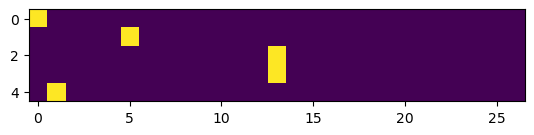

In [17]:
x_enc = F.one_hot(xs, 27).float()
plt.imshow(x_enc)

## 2.1: Forward Pass

In [39]:
# this is basically the input layer where we multiply each of the 5 inputs for all the 27 columns to 27 neurons
g = torch.Generator().manual_seed(2147483647)
w = torch.randn((27,27),generator=g,requires_grad=True)


In [50]:
logits = x_enc @ w
logits

tensor([[ 1.5649, -0.2377, -0.0279, -1.1009,  0.2852,  0.0099, -1.5472,  0.6040,
          0.0786,  0.9034, -0.4716,  0.7857, -0.3288, -0.4333,  1.3709,  2.9239,
          1.5594, -1.6262,  0.6762, -0.8406,  0.9835, -0.1488, -1.4796,  0.4475,
         -0.0712,  2.4906,  2.4390],
        [ 0.4712,  1.4798,  0.3165,  1.0567,  2.3902,  0.4671, -0.6569,  0.6153,
         -0.6224,  0.5089,  1.3535,  0.2335, -0.4563,  0.0380, -0.5120,  0.5544,
          0.4734, -1.3869,  1.6193,  0.1711,  0.9865,  0.5054,  1.0178, -1.9064,
         -0.4280, -2.1260,  0.9585],
        [ 0.1911,  1.0873,  0.6301,  0.2552,  0.9587, -0.2502,  0.0226, -0.0324,
          1.5524, -0.4498, -1.2351,  1.1157, -0.6749,  0.0757, -0.5600, -0.8280,
          0.8179, -0.7520,  0.9226, -1.4853, -0.2146, -1.1867, -0.6620, -0.2351,
          1.5351,  0.5969, -0.7101],
        [ 0.1911,  1.0873,  0.6301,  0.2552,  0.9587, -0.2502,  0.0226, -0.0324,
          1.5524, -0.4498, -1.2351,  1.1157, -0.6749,  0.0757, -0.5600, -0.8280

In [51]:
# to convert the network to certain probabilities (the properties are that all should be +ve and sum up to 1). we do a e^-x on them
# softmax activation function
counts = logits.exp()
probs = counts/counts.sum(1,keepdim=True)

In [52]:
prob[0] # the likelihood of each of the 27 characters following the previous character
loss = -probs[torch.arange(5),ys].log().mean()
print(loss)

tensor(3.7292, grad_fn=<NegBackward0>)


## 2.2: Backward Pass
1. Reset gradients to zero

In [48]:
w.grad=None
loss.backward()

In [49]:
w.data+=-0.1*w.grad 

## 2.3: Putting everything together
1. Create the dataset for all the bigrams
2. Multiply the bigram by the input (random) weights to get the hidden layer
3. Calculate loss
4. Calculate gradients
5. Update weights
6. Repeat

In [61]:
# we first need to create the bigram training dataset. (x,y)
xs,ys = list(),list()

for word in words:
    characters = ['.'] + list(word) + ['.']
    for ch1,ch2 in zip(characters,characters[1:]):
        ix1, ix2 = stoi[ch1],stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"There are now {len(xs)} bigrams")

There are now 228146 bigrams


In [214]:
def softmax(logits):
    counts = logits.exp()
    return counts/counts.sum(1,keepdim=True)

def iteration(xs,ys,i,weights):
    encoded_x = F.one_hot(xs,num_classes=27).float().permute(1,0,2)
    logits = encoded_x @ weights
    probs = softmax(logits)
    loss = -probs[torch.arange(num),ys].log().mean()
    if i%10==0:
        print(f"Average loss at iteration {i} = {loss}")
    weights.grad = None
    loss.backward()
    weights.data+= -10 * weights.grad
    return loss, weights

def inference(ix,weights,generator):
    out = []
    ix = 0
    while True:
        encoded_x = F.one_hot(torch.tensor([ix]),num_classes=27).float()
        logits = encoded_x @ weights
        probs = softmax(logits)
        ix = torch.multinomial(input=probs,num_samples=1,replacement=True,generator=generator).item()
        out.append(itos[ix])
        if ix==0:
            break
    return ''.join(out)

In [142]:
n_iterations = 200
losses = list()
generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((27,27),requires_grad=True,generator=generator)
weights_nn = torch.zeros((27,27))
for i in range(n_iterations):
    loss,weights_nn = iteration(xs,ys,i,weights)
    losses.append(loss.item())
# losses = [x.item() for x in losses]

Average loss at iteration 0 = 3.758953332901001
Average loss at iteration 10 = 3.1797330379486084
Average loss at iteration 20 = 2.9447529315948486
Average loss at iteration 30 = 2.8213977813720703
Average loss at iteration 40 = 2.7462172508239746
Average loss at iteration 50 = 2.6950621604919434
Average loss at iteration 60 = 2.657698154449463
Average loss at iteration 70 = 2.6292762756347656
Average loss at iteration 80 = 2.60709810256958
Average loss at iteration 90 = 2.5894384384155273
Average loss at iteration 100 = 2.5751142501831055
Average loss at iteration 110 = 2.56329345703125
Average loss at iteration 120 = 2.5533816814422607
Average loss at iteration 130 = 2.544954538345337
Average loss at iteration 140 = 2.5377044677734375
Average loss at iteration 150 = 2.5314064025878906
Average loss at iteration 160 = 2.525892496109009
Average loss at iteration 170 = 2.5210323333740234
Average loss at iteration 180 = 2.5167250633239746
Average loss at iteration 190 = 2.512888193130493


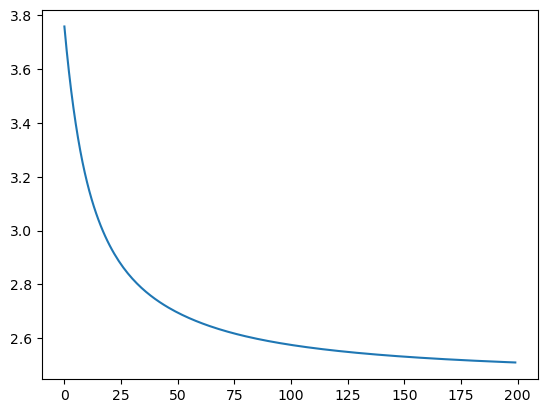

In [143]:
plt.plot(losses)

In [154]:
for i in range(10):
    print(inference(xs,weights_nn,generator))

amalyn.
de.
ues.
hudatlan.
kfjqlsxxnissuzahibeleror.
jaharzh.
ke.
di.
lehanainen.
neylen.


# 3. Exercises

#### 3.1: Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
Observation: Using a trigram model gave me a similar loss (trigram = 2.6, bigram = 2.5) but the words coming out were absolute gibberish. The reason we take 54 nuerons for the first input is because for the input instead of just the first 27 characters we have another set of 27 possible characters. So the encoded representation, which has been concattenated over axis=1 (added to column), is 54.

In [10]:
x1_list,x2_list,ys = list(),list(),list()

for word in words:
    characters = ['.']+list(word)+['.']
    for x1,x2,y in zip(characters[:],characters[1:],characters[2:]):
        x1_list.append(stoi[x1])
        x2_list.append(stoi[x2])
        y = stoi[y]
        ys.append(y)
        # print(f'Given {x} what is the probability that {y}')
x1 = torch.tensor(x1_list)
x2 = torch.tensor(x2_list)
ys = torch.tensor(ys)
num = x1.nelement()

In [17]:
x1_enc = F.one_hot(x1,num_classes=27)
x2_enc = F.one_hot(x2,num_classes=27)
xs = torch.concat((x1_enc,x2_enc),dim=1).float()
xs.shape

torch.Size([196113, 54])

In [26]:
def softmax(logits):
    counts = logits.exp()
    return counts/counts.sum(1,keepdim=True)

def iteration(xs,ys,i,weights):
    # encoded_x = F.one_hot(xs,num_classes=27).float()
    logits = xs @ weights
    probs = softmax(logits)
    # print(probs.shape)
    loss = -probs[torch.arange(num),ys].log().mean()
    if i%10==0:
        print(f"Average loss at iteration {i} = {loss}")
    weights.grad = None
    loss.backward()
    weights.data+= -100 * weights.grad
    return loss, weights

def inference(weights,generator):
    out = []
    ix = 0
    while True:
        encoded_x = F.one_hot(torch.tensor([ix]),num_classes=54).float()
        logits = encoded_x @ weights
        probs = softmax(logits)
        ix = torch.multinomial(input=probs,num_samples=1,replacement=True,generator=generator).item()
        out.append(itos[ix])
        if ix==0:
            break
    return ''.join(out)

In [27]:
n_iterations = 100
losses = list()
generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((54,27),requires_grad=True,generator=generator)
weights_nn = torch.zeros((54,27))
for i in range(n_iterations):
    loss,weights_nn = iteration(xs,ys,i,weights)
    losses.append(loss.item())
# losses = [x.item() for x in losses]

Average loss at iteration 0 = 4.186270713806152
Average loss at iteration 10 = 2.768738269805908
Average loss at iteration 20 = 2.667978525161743
Average loss at iteration 30 = 2.716996908187866
Average loss at iteration 40 = 2.5532851219177246
Average loss at iteration 50 = 2.7231435775756836
Average loss at iteration 60 = 2.5459394454956055
Average loss at iteration 70 = 2.6334586143493652
Average loss at iteration 80 = 2.521024465560913
Average loss at iteration 90 = 2.674325466156006


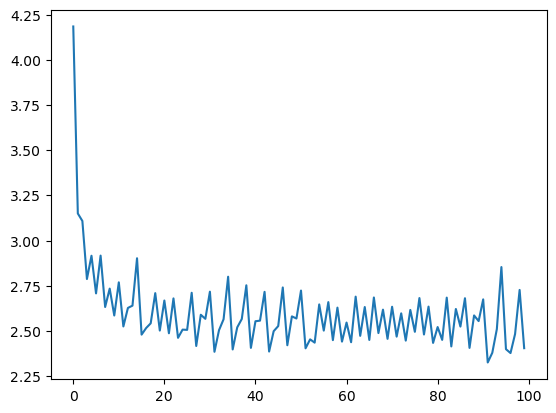

In [28]:
plt.plot(losses)

In [33]:
for i in range(10):
    print(inference(weights_nn,generator))

vpiyaaco.
mregfoeamreo.
u.
ir.
ifkyaiekravn.
vpxzar.
ma.
iilioguancroyho.
ela.
lihregnh.


#### 3.2: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?
The following are the various losses:
1. Bigram:
    - Train: 2.53
    - Dev: 2.61
    - Test: 2.62
2. Trigram:
    - Train: 2.34
    - Dev: 2.7272
    - Test: 2.7277

In [3]:
# creating embedding lookup table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['<START>'] = 0
stoi['<END>'] = 1
itos = {i:s for s,i in stoi.items()}

In [4]:
train = words[:int(0.8*len(words))]
dev = words[int(0.8*len(words)):int(0.9*len(words))]
test = words[int(0.9*len(words)):]

In [5]:
# 1. Bigram model
def create_data(words):
    ys,xs = list(),list()
    for word in words:
        characters = ['<START>'] + list(word) + ['<END>']
        for x,y in zip(characters,characters[1:]):
            x = stoi[x]
            y = stoi[y]
            xs.append(x)
            ys.append(y)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs,ys

def softmax(logits):
    counts = logits.exp()
    return counts/counts.sum(1,keepdim=True)

def iteration(xs,ys,i,weights):
    encoded_x = F.one_hot(xs,num_classes=28).float()
    logits = encoded_x @ weights
    probs = softmax(logits)
    # print(probs.shape)
    num = ys.nelement()
    loss = -probs[torch.arange(num),ys].log().mean()
    if i%10==0:
        print(f"Average loss at iteration {i} = {loss}")
    weights.grad = None
    loss.backward()
    weights.data+= -100 * weights.grad
    return loss, weights

def inference(weights,generator):
    out = []
    ix = 0
    while True:
        encoded_x = F.one_hot(torch.tensor([ix]),num_classes=28).float()
        logits = encoded_x @ weights
        probs = softmax(logits)
        ix = torch.multinomial(input=probs,num_samples=1,replacement=True,generator=generator).item()
        if ix==1:
            break
        out.append(itos[ix])
    return ''.join(out)

In [6]:
train_xs,train_ys = create_data(train)
generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((28,28),generator=generator,requires_grad=True)
weights_nn = torch.ones((28,28),requires_grad=True)
losses=list()
for i in range(50):
    loss,weights_nn = iteration(xs=train_xs,ys=train_ys,i=i,weights=weights)
    losses.append(loss.item())

Average loss at iteration 0 = 3.792339563369751
Average loss at iteration 10 = 2.631258964538574
Average loss at iteration 20 = 2.5815131664276123
Average loss at iteration 30 = 2.465186834335327
Average loss at iteration 40 = 2.5354599952697754


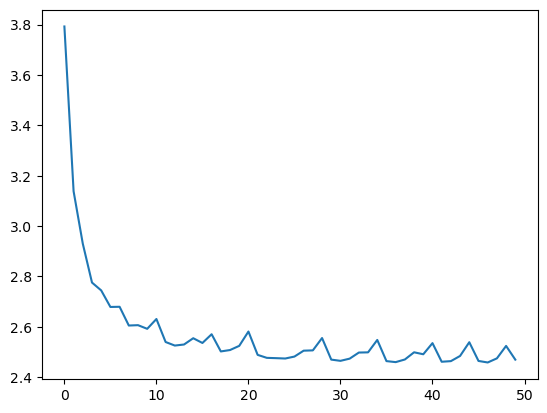

In [7]:
plt.plot(losses)

In [9]:
for _ in range(10): print(inference(weights=weights_nn,generator=generator))
print('sannndh')

mgrydeltitahai
roaqmicanamaljouxayahay
a
danieide
bolannamanah
ch
jamy
chowe
sanowawinelydahanavi
janasken
sannndh


In [10]:
# calculating loss for test set
test_xs,test_ys = create_data(test)
encoded_x = F.one_hot(test_xs,num_classes=28).float()
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = test_ys.nelement()
loss = -probs[torch.arange(num),test_ys].log().mean()
print(f"Average loss for test = {loss}")

Average loss for test = 2.6202170848846436


In [11]:
encoded_x.shape

torch.Size([22735, 28])

In [12]:
# calculating loss for dev set
dev_xs,dev_ys = create_data(dev)
encoded_x = F.one_hot(dev_xs,num_classes=28).float()
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = dev_ys.nelement()
loss = -probs[torch.arange(num),dev_ys].log().mean()
print(f"Average loss for dev = {loss}")

Average loss for dev = 2.613666534423828


In [13]:
# trigram model
def create_data(words):
    x1_list,x2_list,y_list = list(),list(),list()
    for word in words:
        characters = ['<START>'] + list(word) + ['<END>']
        for x1,x2,y in zip(characters,characters[1:],characters[2:]):
            x1 = stoi[x1]
            x2 = stoi[x2]
            y = stoi[y]
            x1_list.append(x1)
            x2_list.append(x2)
            y_list.append(y)
    x1 = torch.tensor(x1_list)
    x2 = torch.tensor(x2_list)
    ys = torch.tensor(y_list)
    return x1,x2,ys

def softmax(logits):
    counts = logits.exp()
    return counts/counts.sum(1,keepdim=True)

def iteration(x1,x2,ys,i,weights):
    encoded_x1 = F.one_hot(x1,num_classes=28).float()
    encoded_x2 = F.one_hot(x2,num_classes=28).float()
    encoded_x = torch.concat((encoded_x1,encoded_x2),dim=1)
    logits = encoded_x @ weights
    probs = softmax(logits)
    # print(probs.shape)
    num = ys.nelement()
    loss = -probs[torch.arange(num),ys].log().mean()
    if i%10==0:
        print(f"Average loss at iteration {i} = {loss}")
    weights.grad = None
    loss.backward()
    weights.data+= -100 * weights.grad
    return loss, weights

def inference(weights,generator):
    out = []
    ix = 0
    while True:
        encoded_x = F.one_hot(torch.tensor([ix]),num_classes=28).float()
        logits = encoded_x @ weights
        probs = softmax(logits)
        ix = torch.multinomial(input=probs,num_samples=1,replacement=True,generator=generator).item()
        if ix==1:
            break
        out.append(itos[ix])
    return ''.join(out)

train_x1,train_x2,train_y = create_data(train)
generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((56,28),generator=generator,requires_grad=True)
weights_nn = torch.ones((56,28),requires_grad=True)
losses=list()
for i in range(50):
    loss,weights_nn = iteration(x1=train_x1,x2=train_x2,ys=train_y,i=i,weights=weights)
    losses.append(loss.item())

Average loss at iteration 0 = 4.328551769256592
Average loss at iteration 10 = 2.964693784713745
Average loss at iteration 20 = 2.41218900680542
Average loss at iteration 30 = 2.641031265258789
Average loss at iteration 40 = 2.349665641784668


In [17]:
# calculating loss for test set
test_x1,test_x2,test_y = create_data(test)
encoded_x1 = F.one_hot(test_x1,num_classes=28).float()
encoded_x2 = F.one_hot(test_x2,num_classes=28).float()
encoded_x = torch.concat((encoded_x1,encoded_x2),dim=1)
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = test_y.nelement()
loss = -probs[torch.arange(num),test_y].log().mean()
print(f"Average loss for test = {loss}")

Average loss for test = 2.727262496948242


In [19]:
# calculating loss for dev set
dev_x1,dev_x2,dev_y = create_data(dev)
encoded_x1 = F.one_hot(dev_x1,num_classes=28).float()
encoded_x2 = F.one_hot(dev_x2,num_classes=28).float()
encoded_x = torch.concat((encoded_x1,encoded_x2),dim=1)
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = dev_y.nelement()
loss = -probs[torch.arange(num),dev_y].log().mean()
print(f"Average loss for dev = {loss}")

Average loss for dev = 2.7277917861938477


#### 3.3: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [6]:
# creating embedding lookup table
chars = sorted(list(set(''.join(words))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['<START>'] = 0
stoi['<END>'] = 1
itos = {i:s for s,i in stoi.items()}

In [7]:
train = words[:int(0.8*len(words))]
dev = words[int(0.8*len(words)):int(0.9*len(words))]
test = words[int(0.9*len(words)):]

In [50]:
train_xs

tensor([ 0,  6, 14,  ..., 10, 19, 19])

In [74]:
num = train_xs.nelement()
num

182778

In [75]:
logits = torch.ones((num,28))
print(logits.shape)
for i,x in enumerate(train_xs):
    idx = x.item()
    logits[i,:] = weights[idx,:]

torch.Size([182778, 28])


In [76]:
(encoded_x @ weights).shape

torch.Size([182778, 28])

In [79]:
np.unique(logits == (encoded_x @ weights))

array([ True])

In [8]:
# 1. Bigram model
def create_data(words):
    ys,xs = list(),list()
    for word in words:
        characters = ['<START>'] + list(word) + ['<END>']
        for x,y in zip(characters,characters[1:]):
            x = stoi[x]
            y = stoi[y]
            xs.append(x)
            ys.append(y)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs,ys

def softmax(logits):
    counts = logits.exp()
    return counts/counts.sum(1,keepdim=True)

def iteration(xs,ys,i,weights):
    # when multiplying with one hot we're basically just getting out that row index 
    logits = torch.ones((num,28))
    for i,x in enumerate(train_xs):
        idx = x.item()
        logits[i,:] = weights[idx,:]
    probs = softmax(logits)
    num = ys.nelement()
    loss = -probs[torch.arange(num),ys].log().mean()
    if i%10==0:
        print(f"Average loss at iteration {i} = {loss}")
    weights.grad = None
    loss.backward()
    weights.data+= -100 * weights.grad
    return loss, weights

def inference(weights,generator):
    out = []
    ix = 0
    while True:
        encoded_x = F.one_hot(torch.tensor([ix]),num_classes=28).float()
        logits = encoded_x @ weights
        probs = softmax(logits)
        ix = torch.multinomial(input=probs,num_samples=1,replacement=True,generator=generator).item()
        if ix==1:
            break
        out.append(itos[ix])
    return ''.join(out)

In [9]:
train_xs,train_ys = create_data(train)
generator = torch.Generator().manual_seed(2147483647)
weights = torch.randn((28,28),generator=generator,requires_grad=True)
weights_nn = torch.ones((28,28),requires_grad=True)
losses=list()
for i in range(50):
    loss,weights_nn = iteration(xs=train_xs,ys=train_ys,i=i,weights=weights)
    losses.append(loss.item())

Average loss at iteration 0 = 3.792339563369751
Average loss at iteration 10 = 2.631258964538574
Average loss at iteration 20 = 2.5815131664276123
Average loss at iteration 30 = 2.465186834335327
Average loss at iteration 40 = 2.5354599952697754


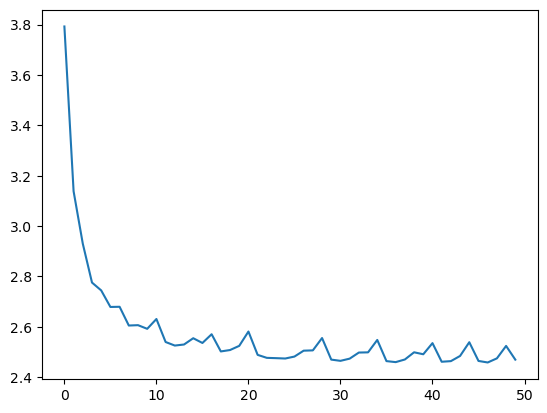

In [10]:
plt.plot(losses)

In [11]:
for _ in range(10): print(inference(weights=weights_nn,generator=generator))
print('sannndh')

ca
te
na
sorilaiaraneyatinllinihilam
rveiridas
gke
a
akanis
alonarech
ainann
sannndh


In [12]:
# calculating loss for test set
test_xs,test_ys = create_data(test)
encoded_x = F.one_hot(test_xs,num_classes=28).float()
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = test_ys.nelement()
loss = -probs[torch.arange(num),test_ys].log().mean()
print(f"Average loss for test = {loss}")

Average loss for test = 2.6202170848846436


In [13]:
encoded_x.shape

torch.Size([22735, 28])

In [14]:
# calculating loss for dev set
dev_xs,dev_ys = create_data(dev)
encoded_x = F.one_hot(dev_xs,num_classes=28).float()
logits = encoded_x @ weights
probs = softmax(logits)
# print(probs.shape)
num = dev_ys.nelement()
loss = -probs[torch.arange(num),dev_ys].log().mean()
print(f"Average loss for dev = {loss}")

Average loss for dev = 2.613666534423828
